In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '219650',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/GGXq2lRAJCtS1yPPPmdVKw__thumb/img/-ERrbcuFZtzZSLfl8grcDi_pCgY=/fit-in/200x150/filters:strip_icc()/pic6205610.png',
  'name': 'Arydia: The Paths We Dare Tread'},
 {'id': '291572',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/gTxav_KKQK1rDg-XuCjCSA__thumb/img/tFTOAKG5aDXxYfNRmJNmfyxH83M=/fit-in/200x150/filters:strip_icc()/pic5164812.jpg',
  'name': 'Oath: Chronicles of Empire and Exile',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 27)
page number = 20 (max: 100, len: 19)
page number = 30 (max: 100, len: 14)
page number = 40 (max: 100, len: 11)
page number = 50 (max: 100, len: 6)
page number = 60 (max: 100, len: 6)
page number = 70 (max: 100, len: 5)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 34, len: 1)
comments_df shape: (110337, 4)


,id,username,rating,value
0,219650,Abaddon1991,N/A,"Kickstarter in 2018? ""Green legacy"""
1,219650,BGG_is_racist57,10,"BGG is racist, deletes uncomfortable opinions,..."
2,219650,BlueFoxMoon,N/A,Pre-release - KS
3,219650,Brehm77,9,I'm very much looking forward to this. I don't...
4,219650,Brighten35,N/A,Yes please.
...,...,...,...,...
110332,167791,z_zadar,9,Some games are so much fun. Others can be a li...
110333,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
110334,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
110335,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 17800 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          17206
10         16606
8          15857
7           8648
N/A         7302
           ...  
9.981          1
7.73           1
7.54           1
8.0974         1
8.73823        1
Name: rating, Length: 587, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(85235, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7302, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Played at Gencon 2017  - don’t think I want to own this one.'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Yet to be played (Jan 2020.  It does have that feel of Kickstarter excess and the need for a bit more refinement, but I enjoyed it (Rating 6.442, March 2021)'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
42/42 - 4s - loss: 0.5798 - accuracy: 0.7503 - val_loss: 0.4965 - val_accuracy: 0.8533
Epoch 2/100
42/42 - 2s - loss: 0.4519 - accuracy: 0.8574 - val_loss: 0.4091 - val_accuracy: 0.8571
Epoch 3/100
42/42 - 2s - loss: 0.3692 - accuracy: 0.8604 - val_loss: 0.3496 - val_accuracy: 0.8623
Epoch 4/100
42/42 - 2s - loss: 0.3123 - accuracy: 0.8756 - val_loss: 0.3207 - val_accuracy: 0.8734
Epoch 5/100
42/42 - 2s - loss: 0.2734 - accuracy: 0.8926 - val_loss: 0.3073 - val_accuracy: 0.8823
Epoch 6/100
42/42 - 2s - loss: 0.2430 - accuracy: 0.9048 - val_loss: 0.3048 - val_accuracy: 0.8848
Epoch 7/100
42/42 - 2s - loss: 0.2184 - accuracy: 0.9155 - val_loss: 0.3088 - val_accuracy: 0.8825
Epoch 8/100
42/42 - 2s - loss: 0.1974 - accuracy: 0.9251 - val_loss: 0.3168 - val_accuracy: 0.8801
Epoch 9/100
42/42 - 2s - loss: 0.1798 - accuracy: 0.9327 - val_loss: 0.3295 - val_accuracy: 0.8782
Epoch 10/100
42/42 - 2s - loss: 0.1644 - accuracy: 0.9392 - val_loss: 0.3428 - val_accuracy: 0.8734
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D687851E80>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

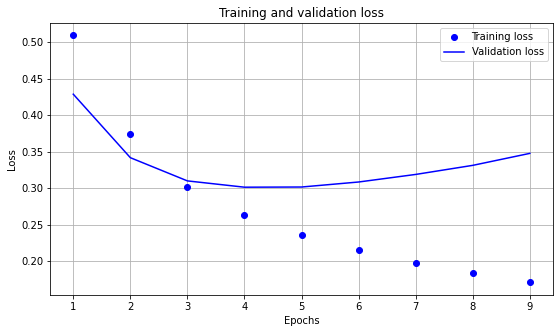

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

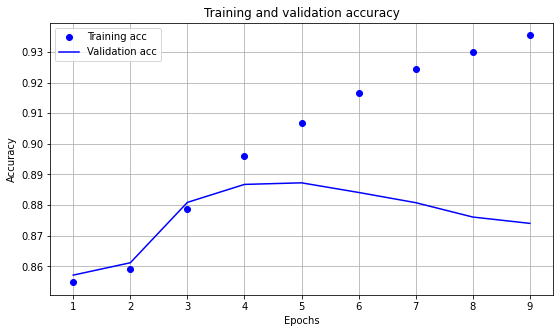

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Played at Gencon 2017  - don’t think I want to own this one."
score: 1.000000
actual: 1

input:
"Entry was a bit hard, best with somebody who can explain the rules. The first rounds then was very good!"
score: 1.000000
actual: 1

input:
"after 10 plays still having a blast, a lighter worker placement which looks great and is easier to teach and play than most euro games."
score: 1.000000
actual: 1

input:
"Okay. In my opinion, this game is just perfect. Why?  - Choose your own battle everytime: choose a villain to fight, choose your hero, build your deck (or pick a premade one), and give it a swing. It's tons of fun to figure out the strengths and weaknesses of both villains and heroes, and adapt to that. The four different aspects work very well with this. - Puzzly gameplay, with tons of (crucial) decisions to make every game.  - Thematically very strong, combined with beautiful, high-quality art.  - Every hero feels unique and playstyle matches very well with the heroes.  - T

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"X-Tides of Ruin + Mac’s Journal + 3D Resources"
score: 1.000000

input:
"only played once, jury's still out "
score: 1.000000

input:
"I've never actually played this, but I'd like to in a year or so. "
score: 0.000000

input:
"2/16/20 Pre-ordered (2) on GN for $35 each. Will be released on 3/19/20 4/28/20 Sold (1) on K for $40. Keeping the other (1)"
score: 1.000000

input:
"Loc: Display Shelf  James: "A long but rewarding game of corporations vying for prestige while greening the red planet. Worth it for any serious gamer. Intermediate.""
score: 1.000000

input:
"- Kickstarter. Art Connossieur. Edición Limitada y   numerada.  Extras: -Pack actualización de idioma completo al castellano. -Monedas 2$ x15 -Monedas 50$ x7 -Todos los diales de poder para el Básico e Invasores de   Tierras Lejanas. -Promo Cartas de Encuentro: 29-42 -Promo Cartas Factoría: 13-18 -Promo Cartas Objetivo: 24-27  Expansiones: -Scyhte: Invasores de Tierras Lejanas. -Scythe: Vientos de Guerra y P

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D9942AE700>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.36


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.02


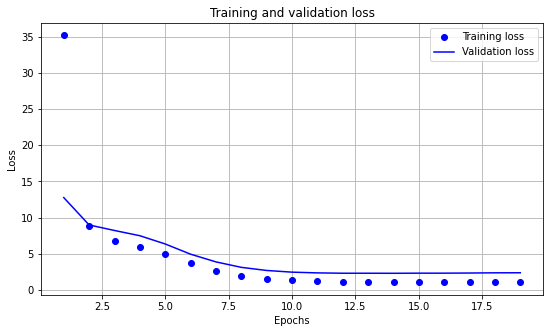

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

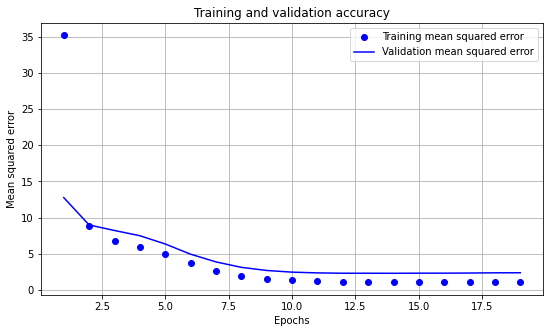

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Played at Gencon 2017  - don’t think I want to own this one."
score: 7.86
actual: 8.00 

input: 
"Entry was a bit hard, best with somebody who can explain the rules. The first rounds then was very good!"
score: 10.36
actual: 9.00 

input: 
"after 10 plays still having a blast, a lighter worker placement which looks great and is easier to teach and play than most euro games."
score: 8.95
actual: 9.00 

input: 
"Okay. In my opinion, this game is just perfect. Why?  - Choose your own battle everytime: choose a villain to fight, choose your hero, build your deck (or pick a premade one), and give it a swing. It's tons of fun to figure out the strengths and weaknesses of both villains and heroes, and adapt to that. The four different aspects work very well with this. - Puzzly gameplay, with tons of (crucial) decisions to make every game.  - Thematically very strong, combined with beautiful, high-quality art.  - Every hero feels unique and playstyle matches very well with the heroes.

## COMPARE CLASSIFIER VS REGRESSOR

In [55]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"Hellas & Elysium Kolonien Konzerne Mini-Erweiterung Nächster Halt: Venus Präludium"
    reg score: 9.06
    clf score: 1

"Premium Health Chips Leather Dice Trays Liberation Logbook Adventure Map"
    reg score: 6.42
    clf score: 1

"The theme is too scary for kids (and us prude adults)"
    reg score: 7.91
    clf score: 1

"Kickstarter - Thematic 1. Voidseekers & Aftermath 2. Terrain Expansion 3. Carnomorphs"
    reg score: 8.54
    clf score: 1

"(2nd Edition) Kickstarter - shipping Aug 2017."
    reg score: 8.00
    clf score: 1

"Matthew is getting this for Christmas"
    reg score: 9.26
    clf score: 1

""In Oath, there are no fancy production tricks, app-assisted mechanisms or production gimmicks."  is exactly what I like to hear from a [b]board game[/b] designer."
    reg score: 8.41
    clf score: 0

"$91 for the base game and Riverfolk expansion. 2019 expansions not yet available."
    reg score: 8.00
    clf score: 1

"fun for two people. Beautiful design. Non-sci-fi the

### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.18 |           3862 |
| 162886 |          8.36 |           3543 |
| 167355 |          8.42 |           1841 |
| 167791 |          8.21 |           8297 |
| 169427 |          8.65 |            240 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.04 |            255 |
| 162886 |          8.10 |            319 |
| 167355 |          8.23 |            216 |
| 167791 |          8.19 |            440 |
| 169427 |          8.23 |             74 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/GGXq2lR...","<a href=""https://boardgamegeek.com/boardgame/2...",6.200000,7.217156,6.899295,1,NaN
1,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.796790,8.036068,7.874555,2,2021
2,"<img src=""https://cf.geekdo-images.com/4Kr0Rer...","<a href=""https://boardgamegeek.com/boardgame/3...",7.500000,NaN,NaN,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.804898,7.978825,7.819092,4,2020
4,"<img src=""https://cf.geekdo-images.com/NPWdxDD...","<a href=""https://boardgamegeek.com/boardgame/3...",7.927143,7.393061,7.766918,5,2020


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Arydia: The Paths We Dare Tread,6.200000,7.217156,6.899295,1,NaN
2,,Oath: Chronicles of Empire and Exile,7.796790,8.036068,7.874555,2,2021
3,,CATAN: 3D Edition,7.500000,NaN,NaN,3,2021
4,,Lost Ruins of Arnak,7.804898,7.978825,7.819092,4,2020
5,,The LOOP,7.927143,7.393061,7.766918,5,2020


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Now or Never,10.000000,7.904535,8.603023,25,2021
2,,Chronicles of Drunagor: Age of Darkness,9.183659,8.447287,9.118203,48,2021
3,,Concordia Solitaria,9.000000,7.817911,8.605970,45,2021
4,,Eclipse: Second Dawn for the Galaxy,8.720986,7.971991,8.606187,41,2020
5,,Brass: Birmingham,8.676880,8.099759,8.625436,21,2018


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.183659,8.447287,9.118203,48,2021
2,,Brass: Birmingham,8.676880,8.099759,8.625436,21,2018
3,,Eclipse: Second Dawn for the Galaxy,8.720986,7.971991,8.606187,41,2020
4,,Concordia Solitaria,9.000000,7.817911,8.605970,45,2021
5,,Now or Never,10.000000,7.904535,8.603023,25,2021


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Awesome.  As described by 3-minute Boardgames - it's the Millennium Falcon, it "may not look like much, but she's got it where it counts".  Interesting and sometimes excruciating decisions.  "
score: 6.07

"[b]Expansions:[/b] [thing=199727][/thing] [thing=211731][/thing] [thing=205121][/thing] [thing=211732][/thing] [thing=211733][/thing] [thing=276229][/thing] [thing=262151][/thing]  [b]Extras:[/b] [thing=268239][/thing] [thing=211947][/thing] [thing=257270][/thing]"
score: 6.19

"cute looking strategy/war game where each animal faction plays totally different Looks very interesting, especially the different factions. Might lack longterm motivation though"
score: 6.26

"Really liked this game. It was pretty simple and straightforward to play, rules-wise, but it took me a while to understand what the strategy of the game was. Ended up scoring poorly my first time, but it was really fun. I would like to play again."
score: 6.30

"Ok, this is not a fair rating. But this is just a board 

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test